In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
pbp_df = pd.read_csv('pbp_data/2022-23.csv')

In [5]:
pbp_df = pbp_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})
pbp_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in pbp_df.GAME_ID.astype(str)]

In [6]:
blocked_shots = pbp_df.loc[(pbp_df.HOMEDESCRIPTION.str.contains("BLK")) | (pbp_df.VISITORDESCRIPTION.str.contains("BLK"))]

In [7]:
player_stats = LeagueDashPlayerStats(season='2022-23', per_mode_detailed='Totals').get_data_frames()[0]



In [8]:
top_blockers = player_stats.sort_values(by='BLK', ascending=False).iloc[:60]

In [9]:
blocked_shots = blocked_shots.loc[blocked_shots.PLAYER3_ID.isin(top_blockers.PLAYER_ID.tolist())]

In [10]:
next_events = []
for index in tqdm.tqdm(range(len(blocked_shots))):
    item = blocked_shots.iloc[index]
    next_item = pbp_df.iloc[pbp_df.loc[(pbp_df.GAME_ID == item.GAME_ID) & (pbp_df.EVENTNUM == item.EVENTNUM)].iloc[0].name+1]
    next_events.append(next_item.EVENTNUM)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2706/2706 [01:03<00:00, 42.49it/s]


In [11]:
blocked_shots.loc[:, 'NEXT_EVENTNUM'] = next_events

In [12]:
merged_blocks = pd.merge(left=blocked_shots, right=pbp_df, left_on=('GAME_ID', 'NEXT_EVENTNUM'), right_on=('GAME_ID', 'EVENTNUM'), suffixes=('_BLK', '_NEXT'))

In [13]:
merged_blocks.PLAYER3_TEAM_ID_BLK = merged_blocks.PLAYER3_TEAM_ID_BLK.astype('str')
merged_blocks.PLAYER1_TEAM_ID_NEXT = merged_blocks.PLAYER1_TEAM_ID_NEXT.astype('str')

In [14]:
reformatted_dfs = []
for index in range(len(top_blockers)):
    item = top_blockers.iloc[index]
    player_id = item.PLAYER_ID
    player_blocks = merged_blocks.loc[merged_blocks.PLAYER3_ID_BLK == player_id]
    is_successful = []
    for cur_index in range(len(player_blocks)):
        block_item = player_blocks.iloc[cur_index]
        if block_item.PLAYER1_TEAM_ID_NEXT == 'nan':
            if str(block_item.PLAYER1_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK).split(".")[0]:
                is_successful.append(1)
            else:
                is_successful.append(0)
        else:
            if str(block_item.PLAYER1_TEAM_ID_NEXT) == str(block_item.PLAYER3_TEAM_ID_BLK):
                is_successful.append(1)
            else:
                is_successful.append(0)
    player_blocks.loc[:, 'SUCCESSFUL'] = is_successful
    reformatted_dfs.append(player_blocks)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
concat_top_blockers = pd.concat(reformatted_dfs)

In [16]:
group_top = concat_top_blockers.groupby('PLAYER3_NAME_BLK').SUCCESSFUL.value_counts().unstack(level=1).reset_index()

In [17]:
renamed_group = group_top.rename(
    columns={
        0: 'UNSUCCESSFUL',
        1: 'SUCCESSFUL'
    }
)

In [18]:
renamed_group.loc[:, 'TOTAL'] = renamed_group.UNSUCCESSFUL + renamed_group.SUCCESSFUL
renamed_group.loc[:, 'SUCC_PCT'] = renamed_group.SUCCESSFUL / renamed_group.TOTAL * 100

In [19]:
sort_blocked = renamed_group.sort_values(by='TOTAL', ascending=False)

In [20]:
sort_blocked

SUCCESSFUL,PLAYER3_NAME_BLK,UNSUCCESSFUL,SUCCESSFUL,TOTAL,SUCC_PCT
8,Brook Lopez,35,71,106,66.981132
45,Nic Claxton,45,59,104,56.730769
28,Jaren Jackson Jr.,35,54,89,60.674157
59,Walker Kessler,38,49,87,56.321839
43,Myles Turner,34,49,83,59.036145
41,Mitchell Robinson,31,35,66,53.030303
7,Bol Bol,23,35,58,60.344828
36,Kristaps Porzingis,20,38,58,65.517241
35,Kevin Durant,23,35,58,60.344828
22,Ivica Zubac,17,39,56,69.642857


In [21]:
plt.style.use('fivethirtyeight')

In [22]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


In [23]:
sort_blocked = sort_blocked.iloc[:20]

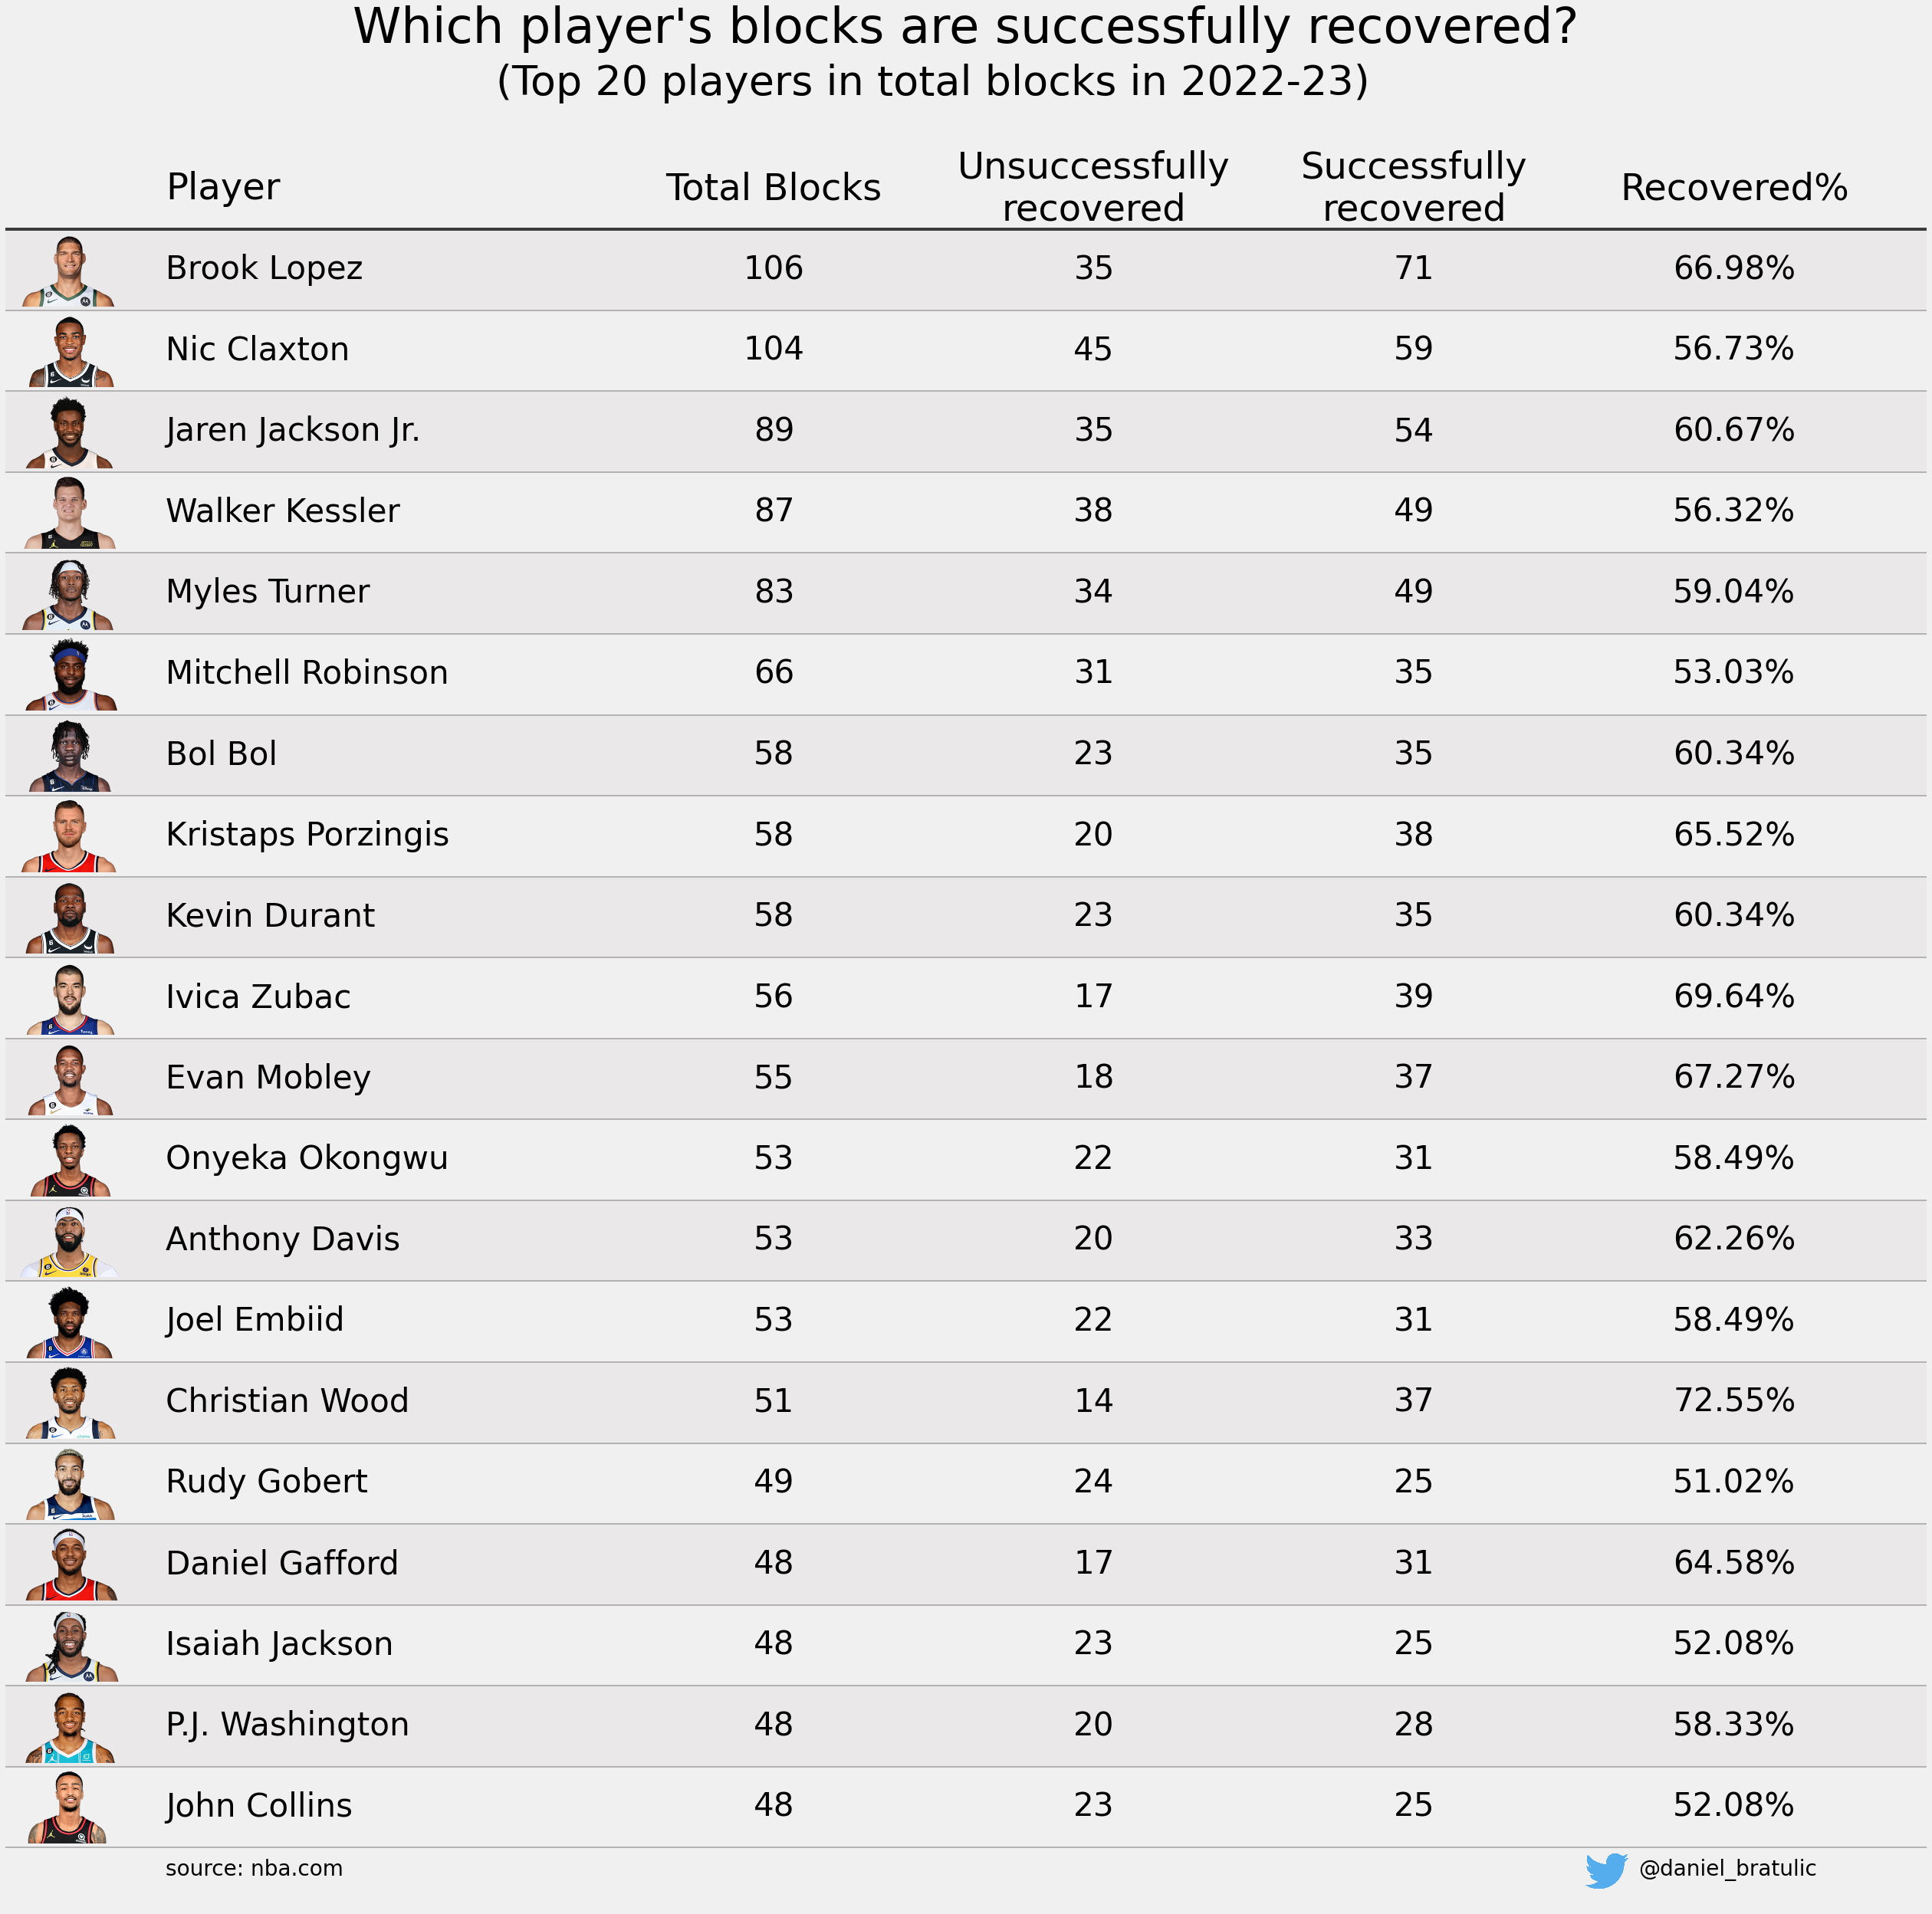

In [25]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 48
title_size = 64
#top = 10

sorted_open_df = sort_blocked
top = len(sort_blocked)
for i in range(top):
    item = sort_blocked.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER3_NAME_BLK)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        rect = Rectangle((-4.5, y_coord + 0.5), width=15, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.PLAYER3_NAME_BLK, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.TOTAL}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.UNSUCCESSFUL}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.SUCCESSFUL}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.SUCC_PCT:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)
ax.text(x=0.25, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=1.2, y=top, ha='center', va='center', s="Total Blocks", size=font_title)
ax.text(x=1.7, y=top, ha='center', va='center', s="Unsuccessfully\nrecovered", size=font_title)
ax.text(x=2.2, y=top, ha='center', va='center', s="Successfully\nrecovered", size=font_title)
ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("Which player's blocks are successfully recovered?\n", size=title_size)
plt.suptitle("(Top 20 players in total blocks in 2022-23)", size=title_size-10, y=0.9, )
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0, right=3)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (2.5, -0.8), frameon=False)
ax.add_artist(ab)
ax.text(x=2.55, y=-0.85, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.25, y=-0.85, ha='left', s='source: nba.com', size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## Rim Deterrence

In [4]:
shotchart_all = ShotChartDetail(player_id=0, team_id=0, context_measure_simple='FGA', season_nullable='2022-23', timeout=900).get_data_frames()[0]

shotchart_all.LOC_X = -shotchart_all.LOC_X

In [5]:
full_df = pd.read_csv('pbp_players/alternate_2_2022-23.csv')

In [6]:
full_df.loc[:, "PCTIMESECONDS"] = [720 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) if item.PERIOD < 5 else 300 - (int(item.PCTIMESTRING.split(":")[0]) * 60 + int(item.PCTIMESTRING.split(":")[1])) for index, item in full_df.iterrows()]

full_df = full_df.fillna({
    "HOMEDESCRIPTION": "",
    "NEUTRALDESCRIPTION": "",
    "VISITORDESCRIPTION": ""
})

In [7]:
full_df.loc[:, 'GAME_ID'] = [f"00{item}" for item in full_df.GAME_ID.astype(str)]

In [8]:
player_teams = {
    'Rudy Gobert': 'Minnesota Timberwolves',
    'Myles Turner': 'Indiana Pacers',
    'Joel Embiid': 'Philadelphia 76ers',
    'Evan Mobley': 'Cleveland Cavaliers',
    'Brook Lopez': 'Milwaukee Bucks',
    'DeAndre Ayton': 'Phoenix Suns',
    'Nikola Jokic': 'Denver Nuggets',
    'Christian Wood': 'Dallas Mavericks',
    'Kristaps Porzingis': 'Washington Wizards',
    'Mitchell Robinson': 'New York Knicks',
    'Robert Williams III': 'Boston Celtics',
    'Walker Kessler': 'Utah Jazz',
    'Nicolas Claxton': 'Brooklyn Nets',
    'Jakob Poeltl': 'San Antonio Spurs',
    'Jaren Jackson Jr.': 'Memphis Grizzlies'
}

In [9]:
target_player_columns = [
    'TEAM_1_PLAYER_1', 'TEAM_1_PLAYER_2', 'TEAM_1_PLAYER_3',
    'TEAM_1_PLAYER_4', 'TEAM_1_PLAYER_5', 'TEAM_2_PLAYER_1',
    'TEAM_2_PLAYER_2', 'TEAM_2_PLAYER_3', 'TEAM_2_PLAYER_4',
    'TEAM_2_PLAYER_5'
]

def get_on_floor(player_id, df):
    queries = [df[key] == player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query | cur
    return df.loc[query]


def get_off_floor(player_id, df):
    queries = [df[key] != player_id for key in target_player_columns]
    query = queries[0]
    for cur in queries[1:]:
        query = query & cur
    return df.loc[query]


def check_any(item, player_id):
    for col in target_player_columns:
        if item[col] == player_id:
            return True
    return False


In [10]:
find_players_by_full_name("Claxton")

[{'id': 1127,
  'full_name': 'Charles Claxton',
  'first_name': 'Charles',
  'last_name': 'Claxton',
  'is_active': False},
 {'id': 1629651,
  'full_name': 'Nic Claxton',
  'first_name': 'Nic',
  'last_name': 'Claxton',
  'is_active': True},
 {'id': 2049,
  'full_name': 'Speedy Claxton',
  'first_name': 'Speedy',
  'last_name': 'Claxton',
  'is_active': False}]

In [11]:
#key = ['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_ZONE_BASIC']
key = ['SHOT_ZONE_BASIC']

defense_dfs = {}

for player in player_teams:
    if player == 'Nicolas Claxton':
        pl_id = find_players_by_full_name('Nic Claxton')[0]['id']
    else:
        pl_id = find_players_by_full_name(player)[0]['id']
    team_id = find_teams_by_full_name(player_teams[player])[0]['id']
    
    player_on_floor = get_on_floor(pl_id, full_df)
    player_off_floor = get_off_floor(pl_id, full_df)
    player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

    shot_off_court = pd.merge(left=shotchart_all, right=player_off_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    shot_on_court = pd.merge(left=shotchart_all, right=player_on_floor, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))
    
    non_team_on_court = shot_on_court.loc[shot_on_court.TEAM_ID != team_id]
    non_team_off_court = shot_off_court.loc[shot_off_court.TEAM_ID != team_id]
    
    
    grouped_off = non_team_off_court.groupby(key).sum().reset_index()
    grouped_off = grouped_off.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_off.loc[:, 'FG_PCT'] = grouped_off.SHOT_MADE_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG * 100
    grouped_off.loc[:, 'PCT_OF_SHOTS'] = grouped_off.SHOT_ATTEMPTED_FLAG / grouped_off.SHOT_ATTEMPTED_FLAG.sum() * 100

    grouped_on = non_team_on_court.groupby(key).sum().reset_index()
    grouped_on = grouped_on.loc[:, key + ['SHOT_MADE_FLAG', 'SHOT_ATTEMPTED_FLAG']]
    grouped_on.loc[:, 'FG_PCT'] = grouped_on.SHOT_MADE_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG * 100
    grouped_on.loc[:, 'PCT_OF_SHOTS'] = grouped_on.SHOT_ATTEMPTED_FLAG / grouped_on.SHOT_ATTEMPTED_FLAG.sum() * 100
    
    merged_defender_df = pd.merge(left=grouped_on, right=grouped_off, on=key, suffixes=('_ON', '_OFF'))
    defense_dfs[player] = merged_defender_df

In [32]:
defense_dfs['Joel Embiid']

,SHOT_ZONE_BASIC,SHOT_MADE_FLAG_ON,SHOT_ATTEMPTED_FLAG_ON,FG_PCT_ON,PCT_OF_SHOTS_ON,SHOT_MADE_FLAG_OFF,SHOT_ATTEMPTED_FLAG_OFF,FG_PCT_OFF,PCT_OF_SHOTS_OFF
0,Above the Break 3,203,606,33.498350,29.793510,94,256,36.718750,31.488315
1,Backcourt,0,4,0.000000,0.196657,0,1,0.000000,0.123001
2,In The Paint (Non-RA),148,367,40.326975,18.043265,43,136,31.617647,16.728167
3,Left Corner 3,31,89,34.831461,4.375615,12,40,30.000000,4.920049
4,Mid-Range,134,309,43.365696,15.191740,37,80,46.250000,9.840098
5,Restricted Area,394,585,67.350427,28.761062,180,267,67.415730,32.841328
6,Right Corner 3,31,74,41.891892,3.638151,13,33,39.393939,4.059041


In [33]:
defense_dfs['Joel Embiid'].SHOT_ATTEMPTED_FLAG_ON.sum()

2034

In [12]:
mappings = {
    'Above the Break 3': 'ATB_3',
    'In The Paint (Non-RA)': 'PAINT',
    'Corner 3': 'CORNER',
    'Mid-Range': 'MID',
    'Restricted Area': 'RA',
}

In [28]:
df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')]

,SHOT_ZONE_BASIC,SHOT_MADE_FLAG_ON,SHOT_ATTEMPTED_FLAG_ON,FG_PCT_ON,PCT_OF_SHOTS_ON,SHOT_MADE_FLAG_OFF,SHOT_ATTEMPTED_FLAG_OFF,FG_PCT_OFF,PCT_OF_SHOTS_OFF
3,Left Corner 3,26,69,37.681159,4.953338,13,43,30.232558,3.662692
6,Right Corner 3,19,64,29.687500,4.594401,18,40,45.000000,3.407155


In [26]:
df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')].sum()

SHOT_ZONE_BASIC            Left Corner 3Right Corner 3
SHOT_MADE_FLAG_ON                                   45
SHOT_ATTEMPTED_FLAG_ON                             133
FG_PCT_ON                                      67.3687
PCT_OF_SHOTS_ON                                9.54774
SHOT_MADE_FLAG_OFF                                  31
SHOT_ATTEMPTED_FLAG_OFF                             83
FG_PCT_OFF                                     75.2326
PCT_OF_SHOTS_OFF                               7.06985
dtype: object

In [30]:
a = df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')]

In [31]:
a.SHOT_MADE_FLAG_ON.sum()

45

In [29]:
df.columns

Index(['SHOT_ZONE_BASIC', 'SHOT_MADE_FLAG_ON', 'SHOT_ATTEMPTED_FLAG_ON',
       'FG_PCT_ON', 'PCT_OF_SHOTS_ON', 'SHOT_MADE_FLAG_OFF',
       'SHOT_ATTEMPTED_FLAG_OFF', 'FG_PCT_OFF', 'PCT_OF_SHOTS_OFF'],
      dtype='object')

In [43]:
print_data = []

for player in defense_dfs:
    df = defense_dfs[player]
    cur_dict = {
        'PLAYER': player
    }
    for key in mappings:
        if key == 'Corner 3':
            cur_df = df.loc[(df.SHOT_ZONE_BASIC == 'Left Corner 3') | (df.SHOT_ZONE_BASIC == 'Right Corner 3')]
            cur_df = pd.DataFrame(data={
                'SHOT_ZONE_BASIC': ['Corner'],
                'SHOT_MADE_FLAG_ON': [cur_df.SHOT_MADE_FLAG_ON.sum()],
                'SHOT_ATTEMPTED_FLAG_ON': [cur_df.SHOT_ATTEMPTED_FLAG_ON.sum()],
                'FG_PCT_ON': [cur_df.SHOT_MADE_FLAG_ON.sum() / cur_df.SHOT_ATTEMPTED_FLAG_ON.sum()],
                'PCT_OF_SHOTS_ON': [cur_df.PCT_OF_SHOTS_ON.sum()],
                'SHOT_MADE_FLAG_OFF': [cur_df.SHOT_MADE_FLAG_OFF.sum()],
                'SHOT_ATTEMPTED_FLAG_OFF': [cur_df.SHOT_ATTEMPTED_FLAG_OFF.sum()],
                'FG_PCT_OFF': [cur_df.SHOT_MADE_FLAG_OFF.sum() / cur_df.SHOT_ATTEMPTED_FLAG_OFF.sum()],
                'PCT_OF_SHOTS_OFF': [cur_df.PCT_OF_SHOTS_OFF.sum()]
            }).iloc[0]
        else:
            cur_df = df.loc[df.SHOT_ZONE_BASIC == key].iloc[0]
        value = mappings[key]
        cur_dict[f"{value}_FG_RATE_ON"] = round(cur_df.PCT_OF_SHOTS_ON, 2)
        cur_dict[f"{value}_FG_RATE_OFF"] = round(cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_RATE_DIFF"] = round(cur_df.PCT_OF_SHOTS_ON - cur_df.PCT_OF_SHOTS_OFF, 2)
        cur_dict[f"{value}_FG_PCT_ON"] = round(cur_df.FG_PCT_ON, 2)
        cur_dict[f"{value}_FG_PCT_OFF"] = round(cur_df.FG_PCT_OFF, 2)
        cur_dict[f"{value}_FG_PCT_DIFF"] = round(cur_df.FG_PCT_ON - cur_df.FG_PCT_OFF, 2)
    print_data.append(cur_dict)
    """paint = df.loc[df.SHOT_ZONE_BASIC == 'In The Paint (Non-RA)'].iloc[0]
    ra = df.loc[df.SHOT_ZONE_BASIC == 'Restricted Area'].iloc[0]
    mid = df.loc[df.SHOT_ZONE_BASIC == 'Mid-Range'].iloc[0]
    print_data.append(
        {
            'PLAYER': player,
            'RA_FG_RATE_ON': round(ra.PCT_OF_SHOTS_ON, 2),
            'RA_FG_RATE_OFF': round(ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_RATE_DIFF': round(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF, 2),
            'RA_FG_PCT_ON': round(ra.FG_PCT_ON, 2),
            'RA_FG_PCT_OFF': round(ra.FG_PCT_OFF, 2),
            'RA_FG_PCT_DIFF': round(ra.FG_PCT_ON - ra.FG_PCT_OFF, 2),
            'PAINT_FG_PCT_DIFF': round(paint.FG_PCT_ON - paint.FG_PCT_OFF, 2),
            'MID_FG_PCT_DIFF': round(mid.FG_PCT_ON - mid.FG_PCT_OFF, 2),
            'PAINT_FG_RATE_DIFF': round(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF, 2),
            'MID_FG_RATE_DIFF': round(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF, 2),
        }
    )"""
    """
    print(f"RA FG% for {player}: {ra.FG_PCT_ON:.2f}")
    print(f"On-Off Diff in RA for {player}: {(ra.FG_PCT_ON - ra.FG_PCT_OFF):.2f}%; Rate: {(ra.PCT_OF_SHOTS_ON - ra.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Paint for {player}: {(paint.FG_PCT_ON - paint.FG_PCT_OFF):.2f}%; Rate: {(paint.PCT_OF_SHOTS_ON - paint.PCT_OF_SHOTS_OFF):.2f}%")
    print(f"On-Off Diff in Mid Range for {player}: {(mid.FG_PCT_ON - mid.FG_PCT_OFF):.2f}%; Rate: {(mid.PCT_OF_SHOTS_ON - mid.PCT_OF_SHOTS_OFF):.2f}%")
    print()
    """
print_df = pd.DataFrame(print_data)

In [46]:
ra_diff_sort.loc[:, ['PLAYER', 'RA_FG_RATE_ON',
       'RA_FG_RATE_OFF', 'RA_FG_RATE_DIFF', 'RA_FG_PCT_ON', 'RA_FG_PCT_OFF',
       'RA_FG_PCT_DIFF']]

,PLAYER,RA_FG_RATE_ON,RA_FG_RATE_OFF,RA_FG_RATE_DIFF,RA_FG_PCT_ON,RA_FG_PCT_OFF,RA_FG_PCT_DIFF
0,Rudy Gobert,28.41,35.71,-7.30,61.49,66.74,-5.25
11,Walker Kessler,28.06,33.36,-5.30,62.42,68.15,-5.73
4,Brook Lopez,25.15,30.15,-5.01,62.10,66.74,-4.65
10,Robert Williams III,23.22,27.39,-4.16,66.94,65.71,1.23
6,Nikola Jokic,29.37,33.51,-4.14,71.82,69.00,2.82
2,Joel Embiid,28.76,32.84,-4.08,67.35,67.42,-0.07
1,Myles Turner,31.89,35.55,-3.66,60.31,65.15,-4.84
14,Jaren Jackson Jr.,30.65,33.39,-2.74,53.86,64.29,-10.42
3,Evan Mobley,30.09,32.14,-2.05,63.57,67.50,-3.93
8,Kristaps Porzingis,27.36,28.40,-1.04,66.13,64.29,1.84


In [47]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
zoom = 0.5

player_root_dir = f'player_imgs/'

def get_player_img(player_id, zoom=0.5):
    #print(path)
    return OffsetImage(plt.imread(f'{player_root_dir}{player_id}.png'), zoom=zoom)


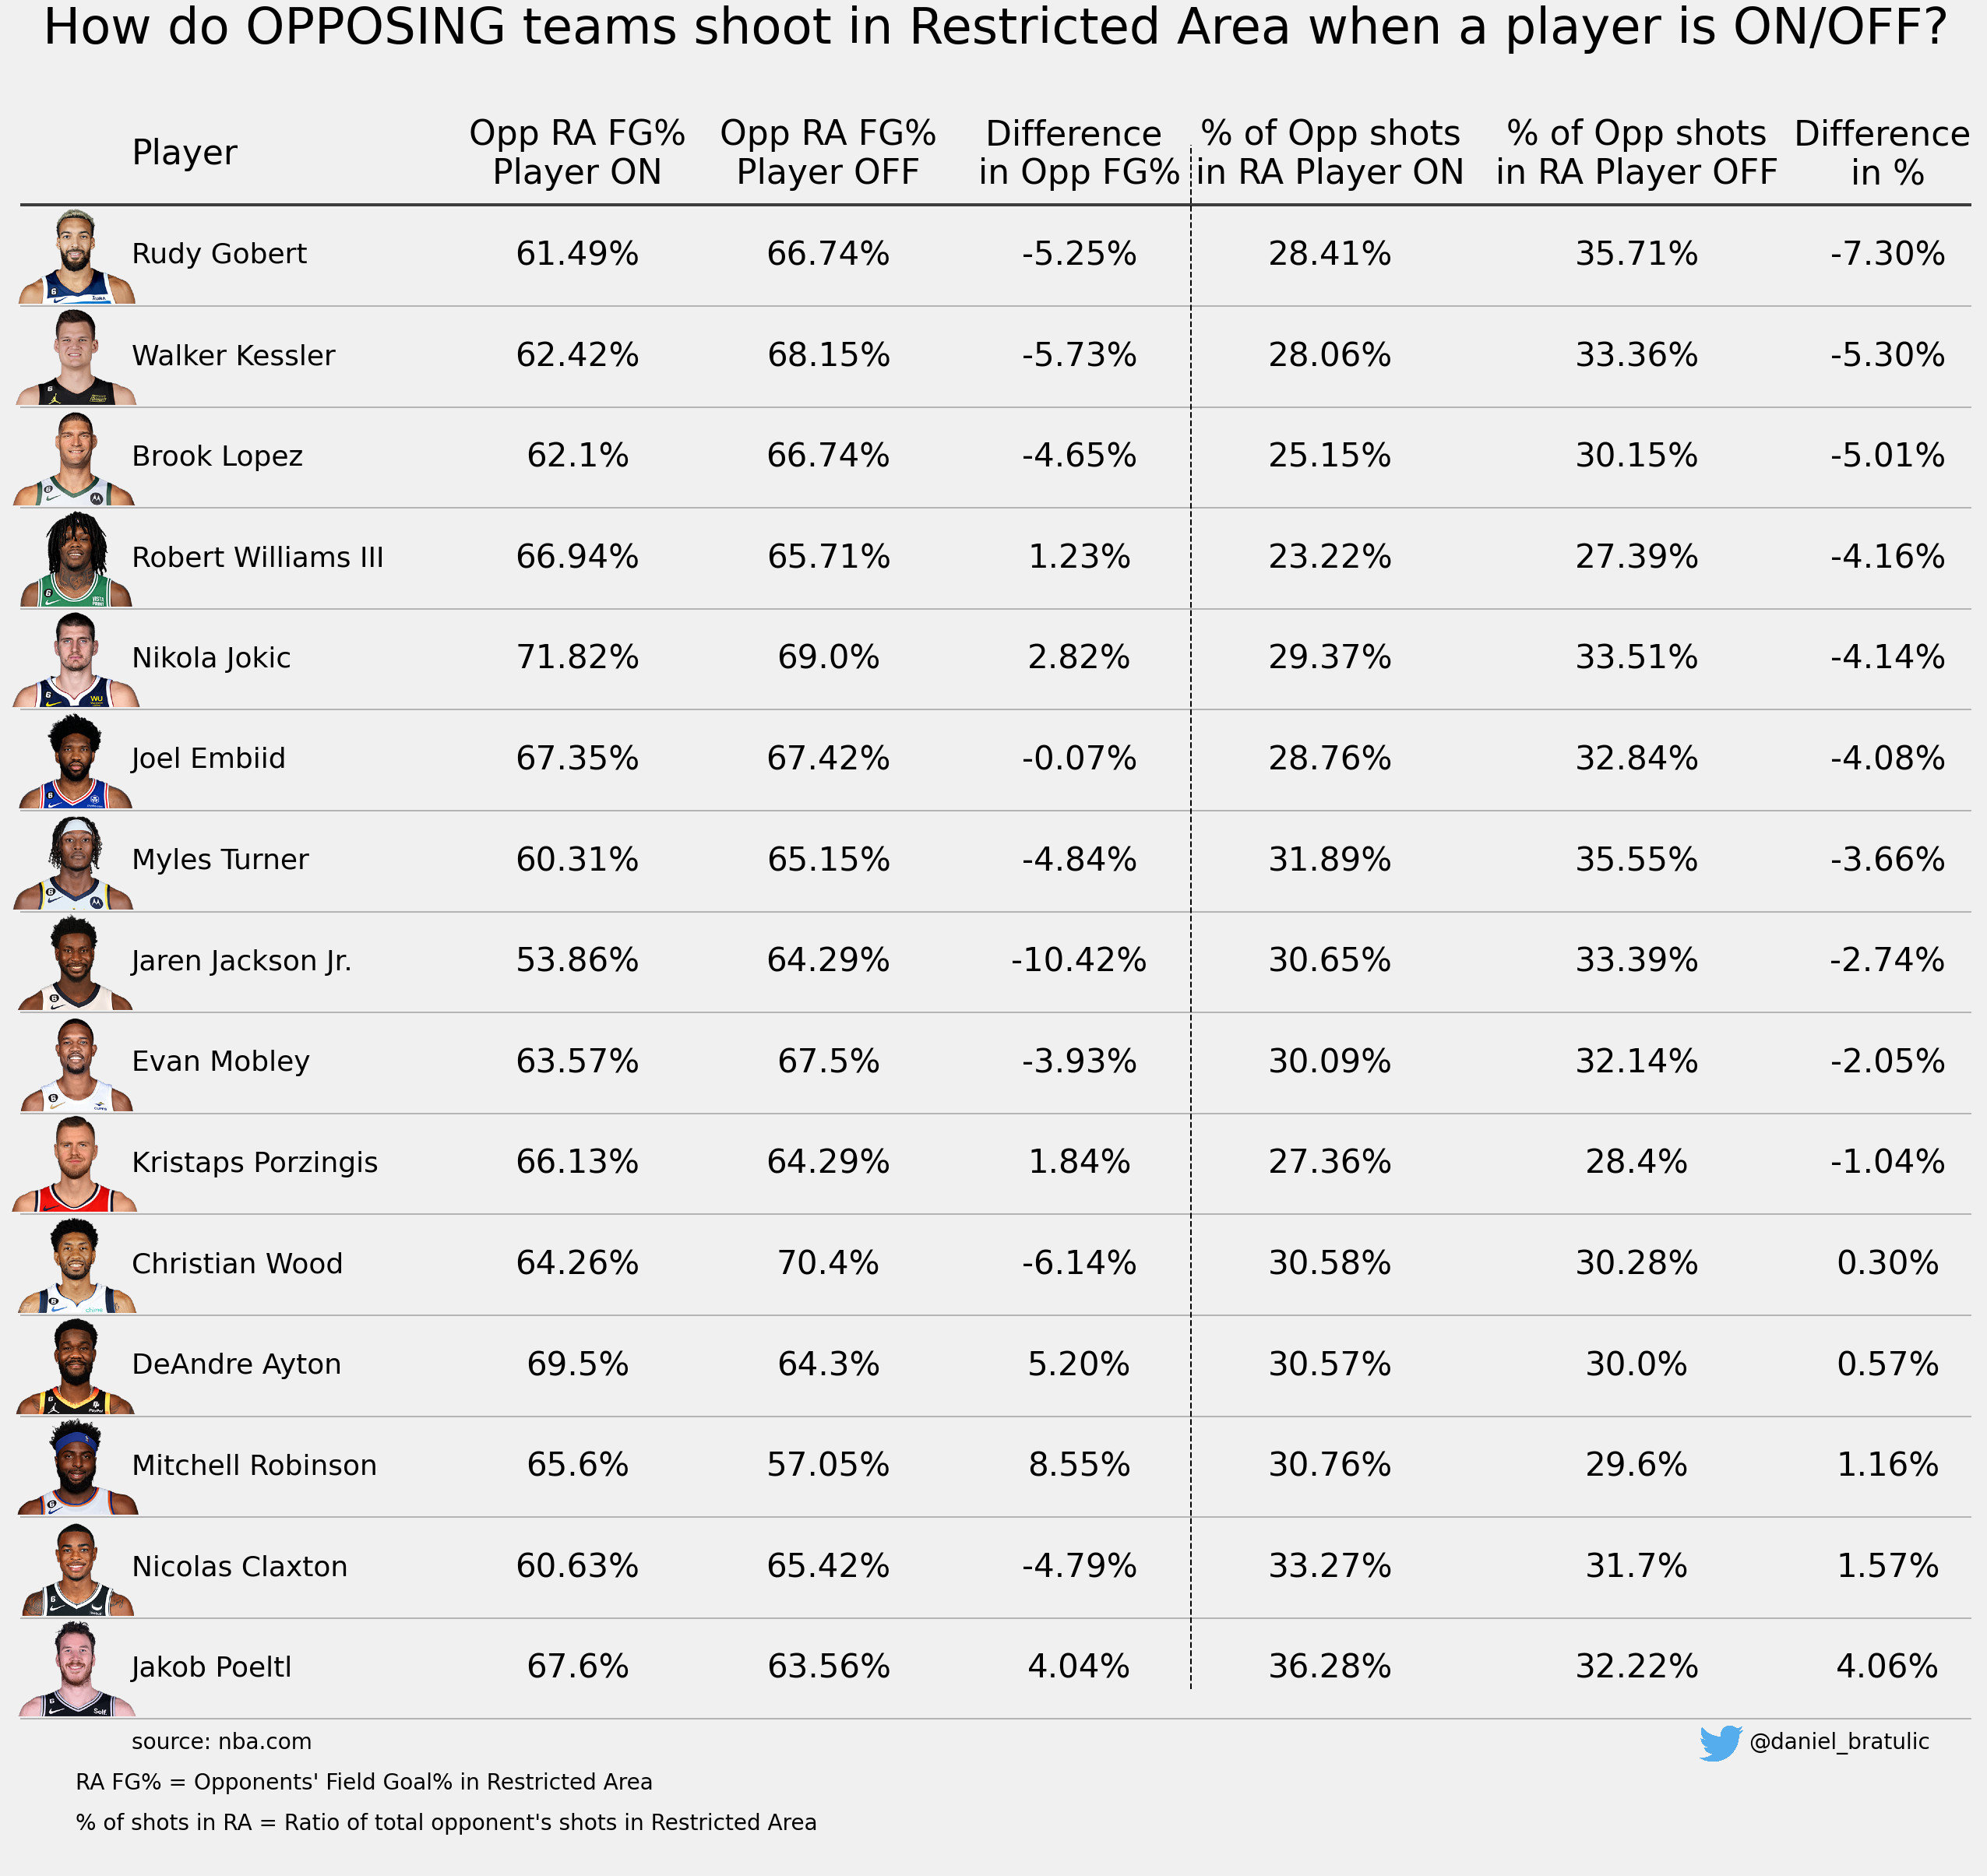

In [48]:
fig, ax = plt.subplots(figsize=(40, 40))
number_size = 42
font_size = 36
font_title = 44
title_size = 64
#top = 10

sorted_open_df = ra_diff_sort
top = len(ra_diff_sort)
for i in range(top):
    item = ra_diff_sort.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER)[0]['id']
    except Exception:
        player_id = find_players_by_full_name('Nic Claxton')[0]['id']
    y_coord = top - i - 1
    #if i % 2 == 1:
    #    color = '#EAE8E8'
    #    rect = Rectangle((-4.5, y_coord + 0.5), width=50, height=1, fill=True, color=color)
    #    ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id, zoom=0.65), (0.2, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.4, y=y_coord, ha='left', va='center', s=item.PLAYER, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=30, color='#A0A0A0', alpha=0.75, lw=2)

    ax.text(x=2.0, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_ON}%", size=number_size)
    ax.text(x=2.9, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_OFF}%", size=number_size)
    ax.text(x=3.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_PCT_DIFF:.2f}%", size=number_size)
    ax.text(x=4.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_ON}%", size=number_size)
    ax.text(x=5.8, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_OFF}%", size=number_size)
    ax.text(x=6.7, y=y_coord, ha='center', va='center', s=f"{item.RA_FG_RATE_DIFF:.2f}%", size=number_size)
    
    #y_img_start = y_coord-0.5 + (1 - 0.730769232) / 2
    #ax.imshow(img, extent=(0, 1.36, y_img_start-0.5, y_img_start + 0.1), aspect='auto')
    #ax.imshow(img, extent=(0, 260, 0, 190), aspect=260/190)
    
#ax.text(x=0.25, y=top, s='Season', ha='left', va='center', size=font_title)

ax.text(x=0.4, y=top, s='Player', ha='left', va='center', size=font_title)
ax.text(x=2.0, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer ON", size=font_title)
ax.text(x=2.9, y=top, ha='center', va='center', s="Opp RA FG%\nPlayer OFF", size=font_title)
ax.text(x=3.8, y=top, ha='center', va='center', s="Difference \nin Opp FG%", size=font_title)
ax.text(x=4.7, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player ON", size=font_title)
ax.text(x=5.8, y=top, ha='center', va='center', s="% of Opp shots\nin RA Player OFF", size=font_title)
ax.text(x=6.7, y=top, ha='center', va='center', s="Difference \nin %", size=font_title)
#ax.text(x=2.7, y=top, ha='center', va='center', s="Recovered%", size=font_title)

#ax.text(x=2.75, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=30)
#ax.text(x=0.25, y=-0.75, s='data: nba.com', ha='left', va='center', size=30)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=30, color='black', alpha=0.75, lw=4)
ax.axvline(x=4.2, ymin=0.1, ymax=0.95, lw=2, color='black', ls='--')
ax.set_title("How do OPPOSING teams shoot in Restricted Area when a player is ON/OFF?", size=title_size)
    
ax.set_ylim(bottom=-2, top=top+1)
ax.set_xlim(left=-0, right=7)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (6.1, -0.75), frameon=False)
ax.add_artist(ab)
ax.text(x=6.2, y=-0.8, ha='left', s='@daniel_bratulic', size=28)
ax.text(x=0.4, y=-0.8, ha='left', s='source: nba.com', size=28)
ax.text(x=0.2, y=-1.2, s="RA FG% = Opponents' Field Goal% in Restricted Area", size=28)
ax.text(x=0.2, y=-1.6, s="% of shots in RA = Ratio of total opponent's shots in Restricted Area", size=28)
plt.savefig('block_recoveries.png', dpi=120, bbox_inches='tight')

## Detailed look at Rudy

In [21]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [49]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = int(((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x)
        unbinned_y = int(((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y)

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
        # Percentage of whole zone (not in comparison with league average)
        copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage

    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [23]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 50),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 50),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (190, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-190, 50),
}

In [24]:
pl_id = find_players_by_full_name("Rudy Gobert")[0]['id']

player_on_floor = get_on_floor(pl_id, full_df)
player_off_floor = get_off_floor(pl_id, full_df)
player_off_floor = player_off_floor.loc[player_off_floor.GAME_ID.isin(player_on_floor.GAME_ID.unique())]

In [25]:
team_id = find_teams_by_full_name("Utah Jazz")[0]['id']

In [26]:
opposing_shots_on = player_on_floor.loc[((player_on_floor.EVENTMSGTYPE == 1) | (player_on_floor.EVENTMSGTYPE == 2)) & (player_on_floor.PLAYER1_TEAM_ID != team_id)]

In [27]:
shot_on_court = pd.merge(left=shotchart_all, right=opposing_shots_on, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

In [28]:
x_on = shot_on_court.LOC_X.to_numpy()

In [29]:
y_on = shot_on_court.LOC_Y.to_numpy()

In [181]:
bin_number_x = 50
bin_number_y = 300 / (500.0 / bin_number_x)

In [183]:
binned_df = create_bins(data_frame=shot_on_court, bin_number_x=bin_number_x, bin_number_y=bin_number_y)

grouped_bins = binned_df.groupby(('BIN_LOC_X', 'BIN_LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

grouped_bins.SHOT_ATTEMPTED_FLAG = grouped_bins.SHOT_ATTEMPTED_FLAG / len(binned_df) * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [185]:
binned_df = create_bins(data_frame=shot_off_court, bin_number_x=bin_number_x, bin_number_y=bin_number_y)

grouped_off_bins = binned_df.groupby(('BIN_LOC_X', 'BIN_LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

grouped_off_bins.SHOT_ATTEMPTED_FLAG = grouped_off_bins.SHOT_ATTEMPTED_FLAG / len(binned_df) * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  This is separate from the ipykernel package so we can avoid doing imports until


In [186]:
merged_binned = pd.merge(left=grouped_bins, right=grouped_off_bins, on=('BIN_LOC_X', 'BIN_LOC_Y'), suffixes=('_ON', '_OFF'))

In [187]:
merged_binned.loc[:, 'DIFF'] = merged_binned.SHOT_ATTEMPTED_FLAG_ON - merged_binned.SHOT_ATTEMPTED_FLAG_OFF

In [188]:
merged_binned.sort_values(by='DIFF', ascending=False).head()

,BIN_LOC_X,BIN_LOC_Y,SHOT_ATTEMPTED_FLAG_ON,SHOT_ATTEMPTED_FLAG_OFF,DIFF
582,225,7,0.620018,0.268017,0.352001
231,-25,17,1.062888,0.714711,0.348176
505,115,237,0.383820,0.089339,0.294482
142,-85,237,0.442870,0.178678,0.264192
220,-35,97,0.265722,0.029780,0.235942


In [197]:
cmap = sns.color_palette("coolwarm", n_colors=6, desat=1)


In [203]:
cmap

[array([0.88339877, 0.63774563, 0.93301505, 1.        ]),
 array([0.92092707, 0.75433781, 0.95457427, 1.        ]),
 array([0.95845538, 0.87092999, 0.97613349, 1.        ]),
 array([0.98027788, 0.87883069, 0.86352671, 1.        ]),
 array([0.96176023, 0.76506138, 0.73538806, 1.        ]),
 array([0.94324258, 0.65129207, 0.60724941, 1.        ])]

In [217]:
cmap = sns.diverging_palette(240, 10, n=6, as_cmap=False, l=50, s=80)

In [218]:
colors = []
for diff in merged_binned.DIFF:
    if diff < -1.5:
        colors.append(cmap[0])
    if diff > -1.5 and diff <= -0.5:
        colors.append(cmap[1])
    if diff > -0.5 and diff <= 0:
        colors.append(cmap[2])
    if diff > 0 and diff <= 0.5:
        colors.append(cmap[3])
    if diff > 0.5 and diff <= 1.5:
        colors.append(cmap[4])
    if diff > 1.5:
        colors.append(cmap[5])

<AxesSubplot:title={'center':'Difference in shot frequency when Rudy Gobert is ON/OFF'}>

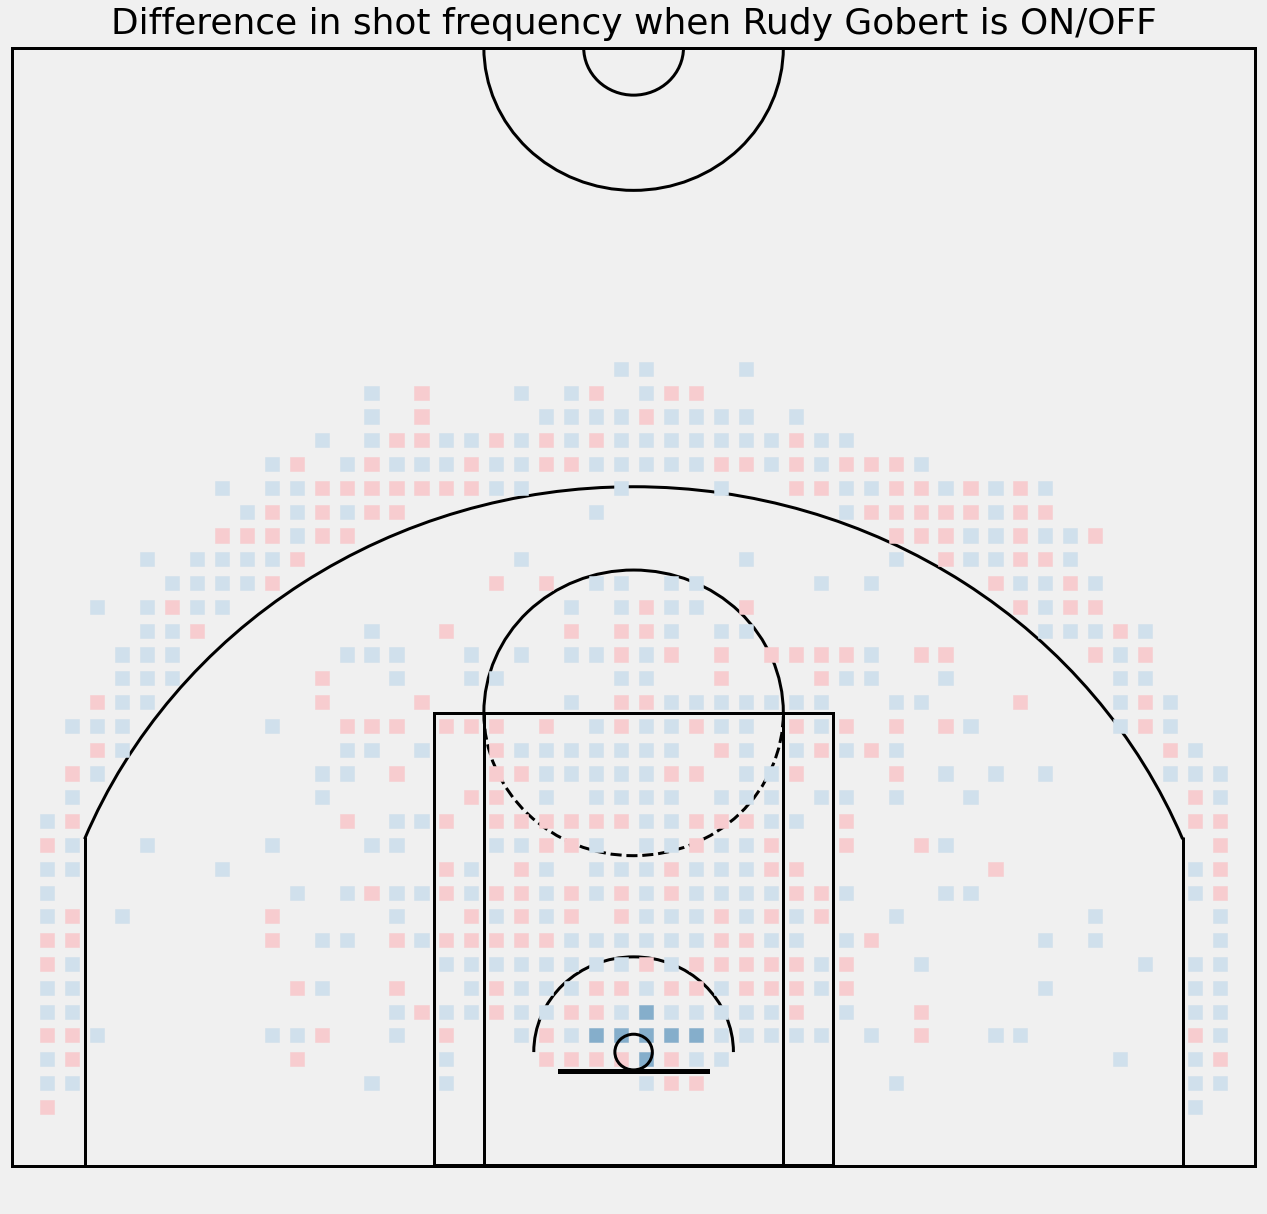

In [219]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

#cmap_list = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"],n_colors=20, as_cmap=False)
cmap = sns.diverging_palette(240, 10, n=9, sep=10, as_cmap=True)
ax.set_title("Difference in shot frequency when Rudy Gobert is ON/OFF", size=36)
#sns.kdeplot(data=merged_binned.BIN_LOC_X, data2=merged_binned.BIN_LOC_Y, hue=merged_binned.DIFF, ax=ax, fill=True,shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
ax.scatter(x=merged_binned.BIN_LOC_X, y=merged_binned.BIN_LOC_Y, c=colors, alpha=1.0, s=200, marker='s')
draw_court(ax=ax,outer_lines=True, lw=3, color='black')

In [224]:
from scipy.stats import kde


## Raw

In [164]:
grouped_on_raw = shot_on_court.groupby(('LOC_X', 'LOC_Y')).SHOT_ATTEMPTED_FLAG.count().reset_index()

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


### Other tests

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is ON the court"}>

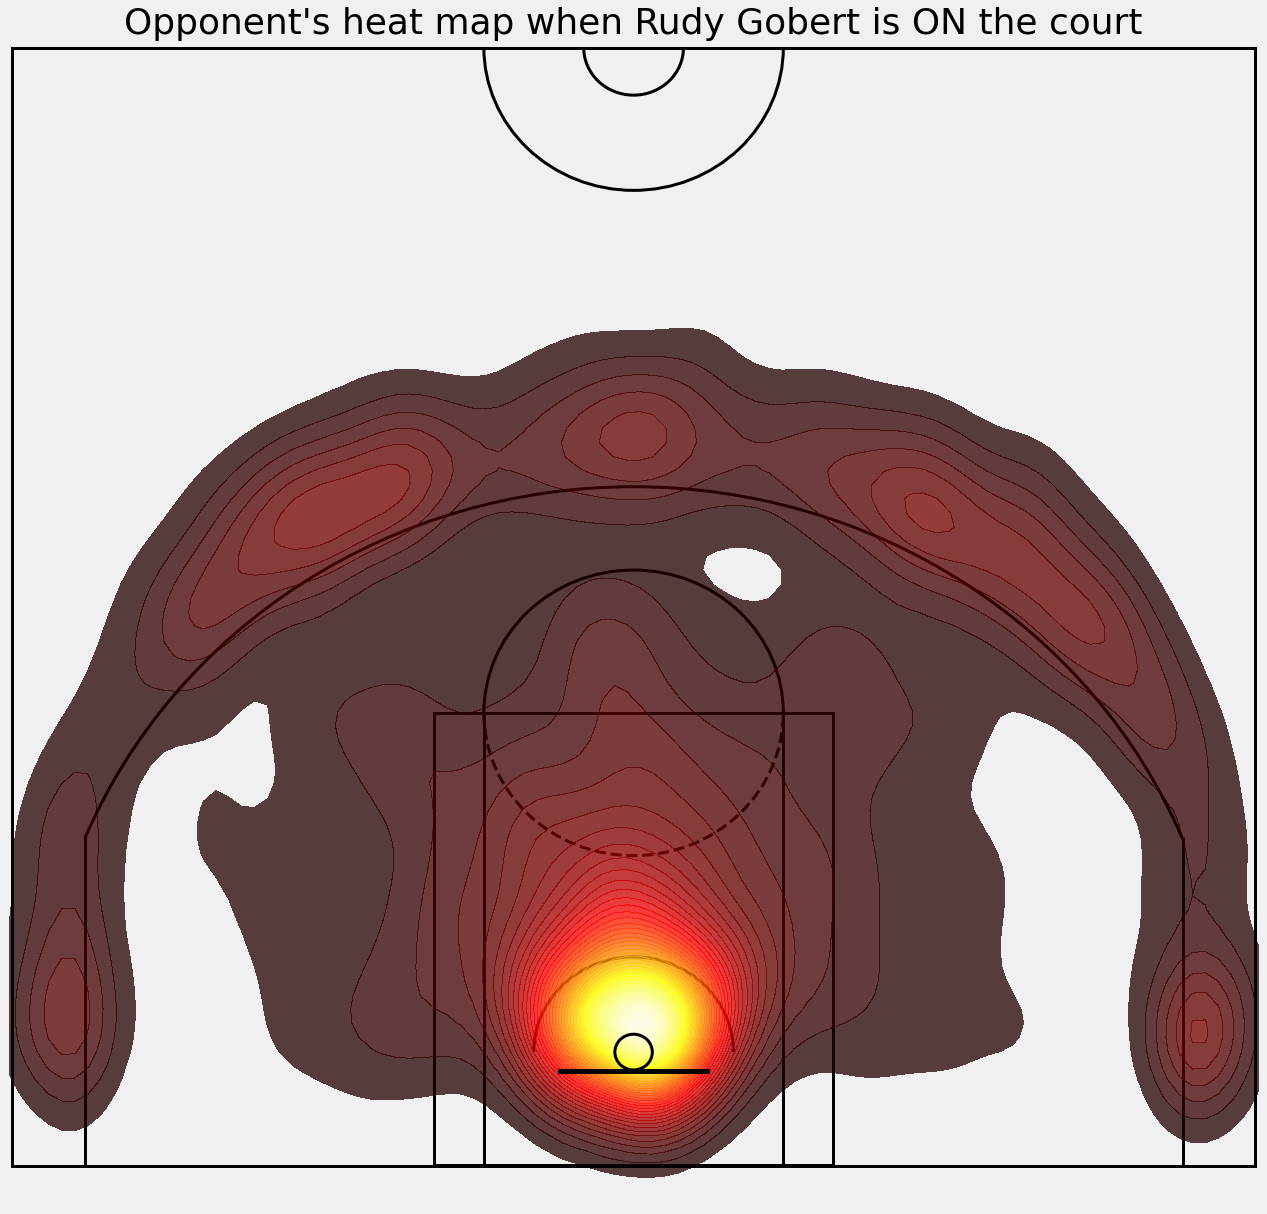

In [131]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

ax.set_title("Opponent's heat map when Rudy Gobert is ON the court", size=36)
sns.kdeplot(data=x_bin_on, data2=y_bin_on, ax=ax, gridsize=100, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
draw_court(ax=ax,outer_lines=True, lw=3, color='black')

In [31]:
opposing_shots_off = player_off_floor.loc[((player_off_floor.EVENTMSGTYPE == 1) | (player_off_floor.EVENTMSGTYPE == 2)) & (player_off_floor.PLAYER1_TEAM_ID != team_id)]

In [87]:
shot_off_court = pd.merge(left=shotchart_all, right=opposing_shots_off, left_on=('GAME_ID', 'GAME_EVENT_ID'), right_on=('GAME_ID', 'EVENTNUM'))

x_off = shot_off_court.LOC_X.to_numpy()

y_off = shot_off_court.LOC_Y.to_numpy()

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is OFF the court"}>

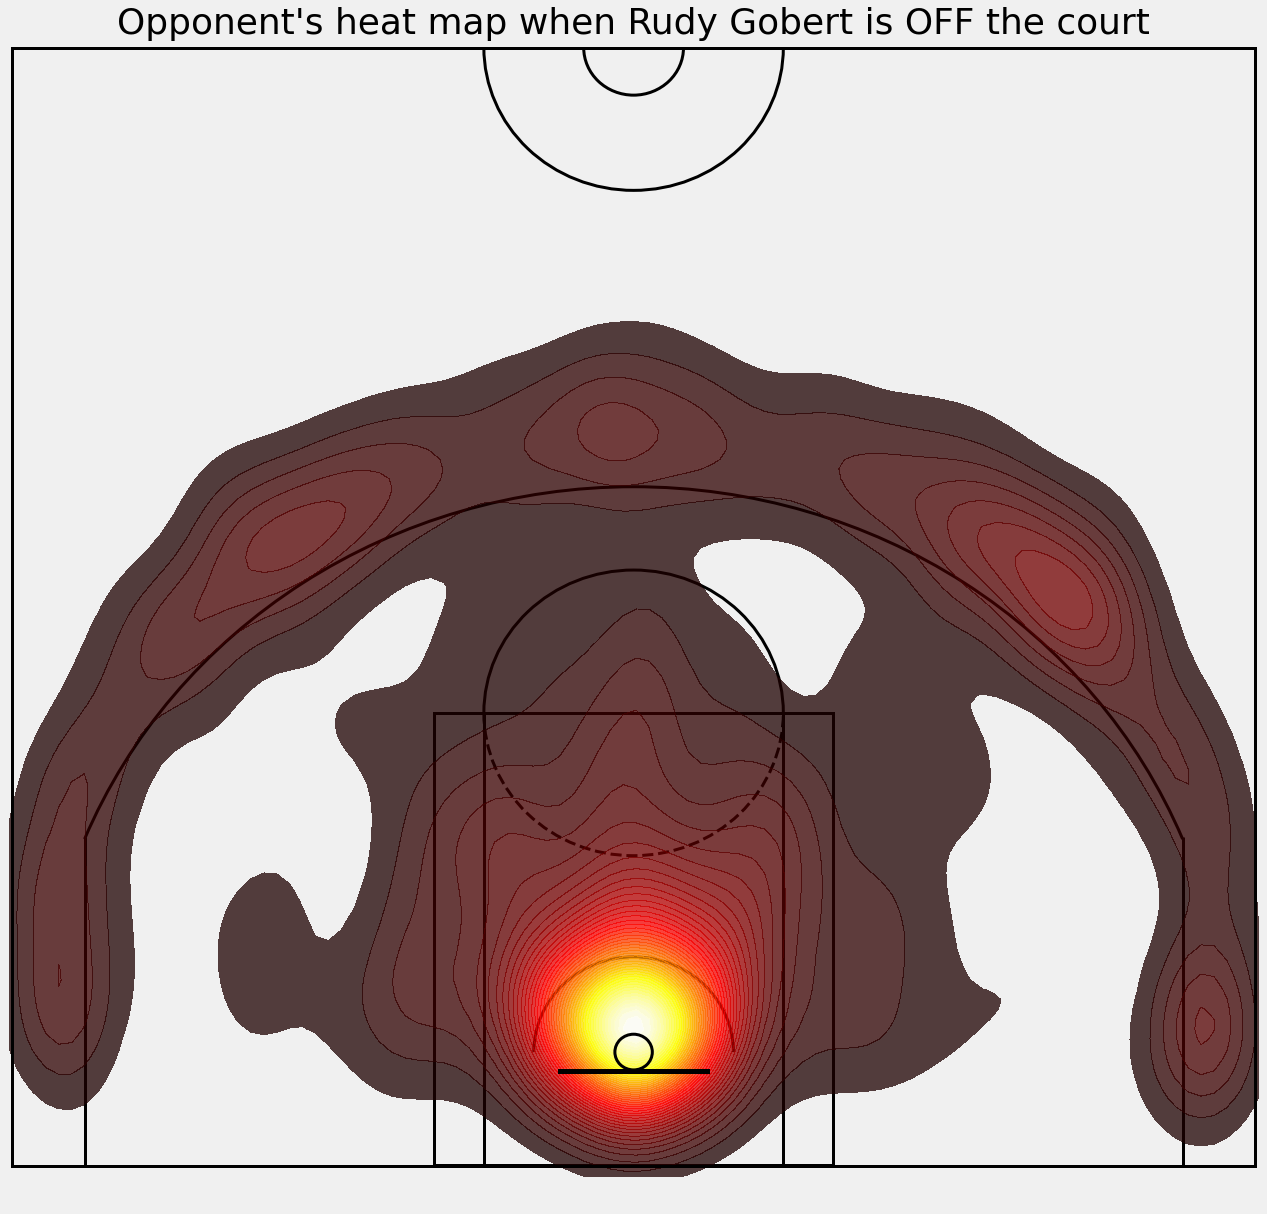

In [108]:
fig, ax = plt.subplots(figsize=(20, 20))
draw_court(ax=ax,outer_lines=True, lw=3, color='black')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.grid(False)
ax.set_xlim(-251,251)
ax.set_ylim(-65,425)

ax.set_title("Opponent's heat map when Rudy Gobert is OFF the court", size=36)
#sns.kdeplot(data=x_on, data2=y_on, ax=ax, cut=1, fill=True, levels=25, shade=True, shade_lowest=False, alpha=0.75)
sns.kdeplot(data=x_off, data2=y_off, ax=ax, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')

<AxesSubplot:title={'center':"Opponent's heat map when Rudy Gobert is OFF the court"}>

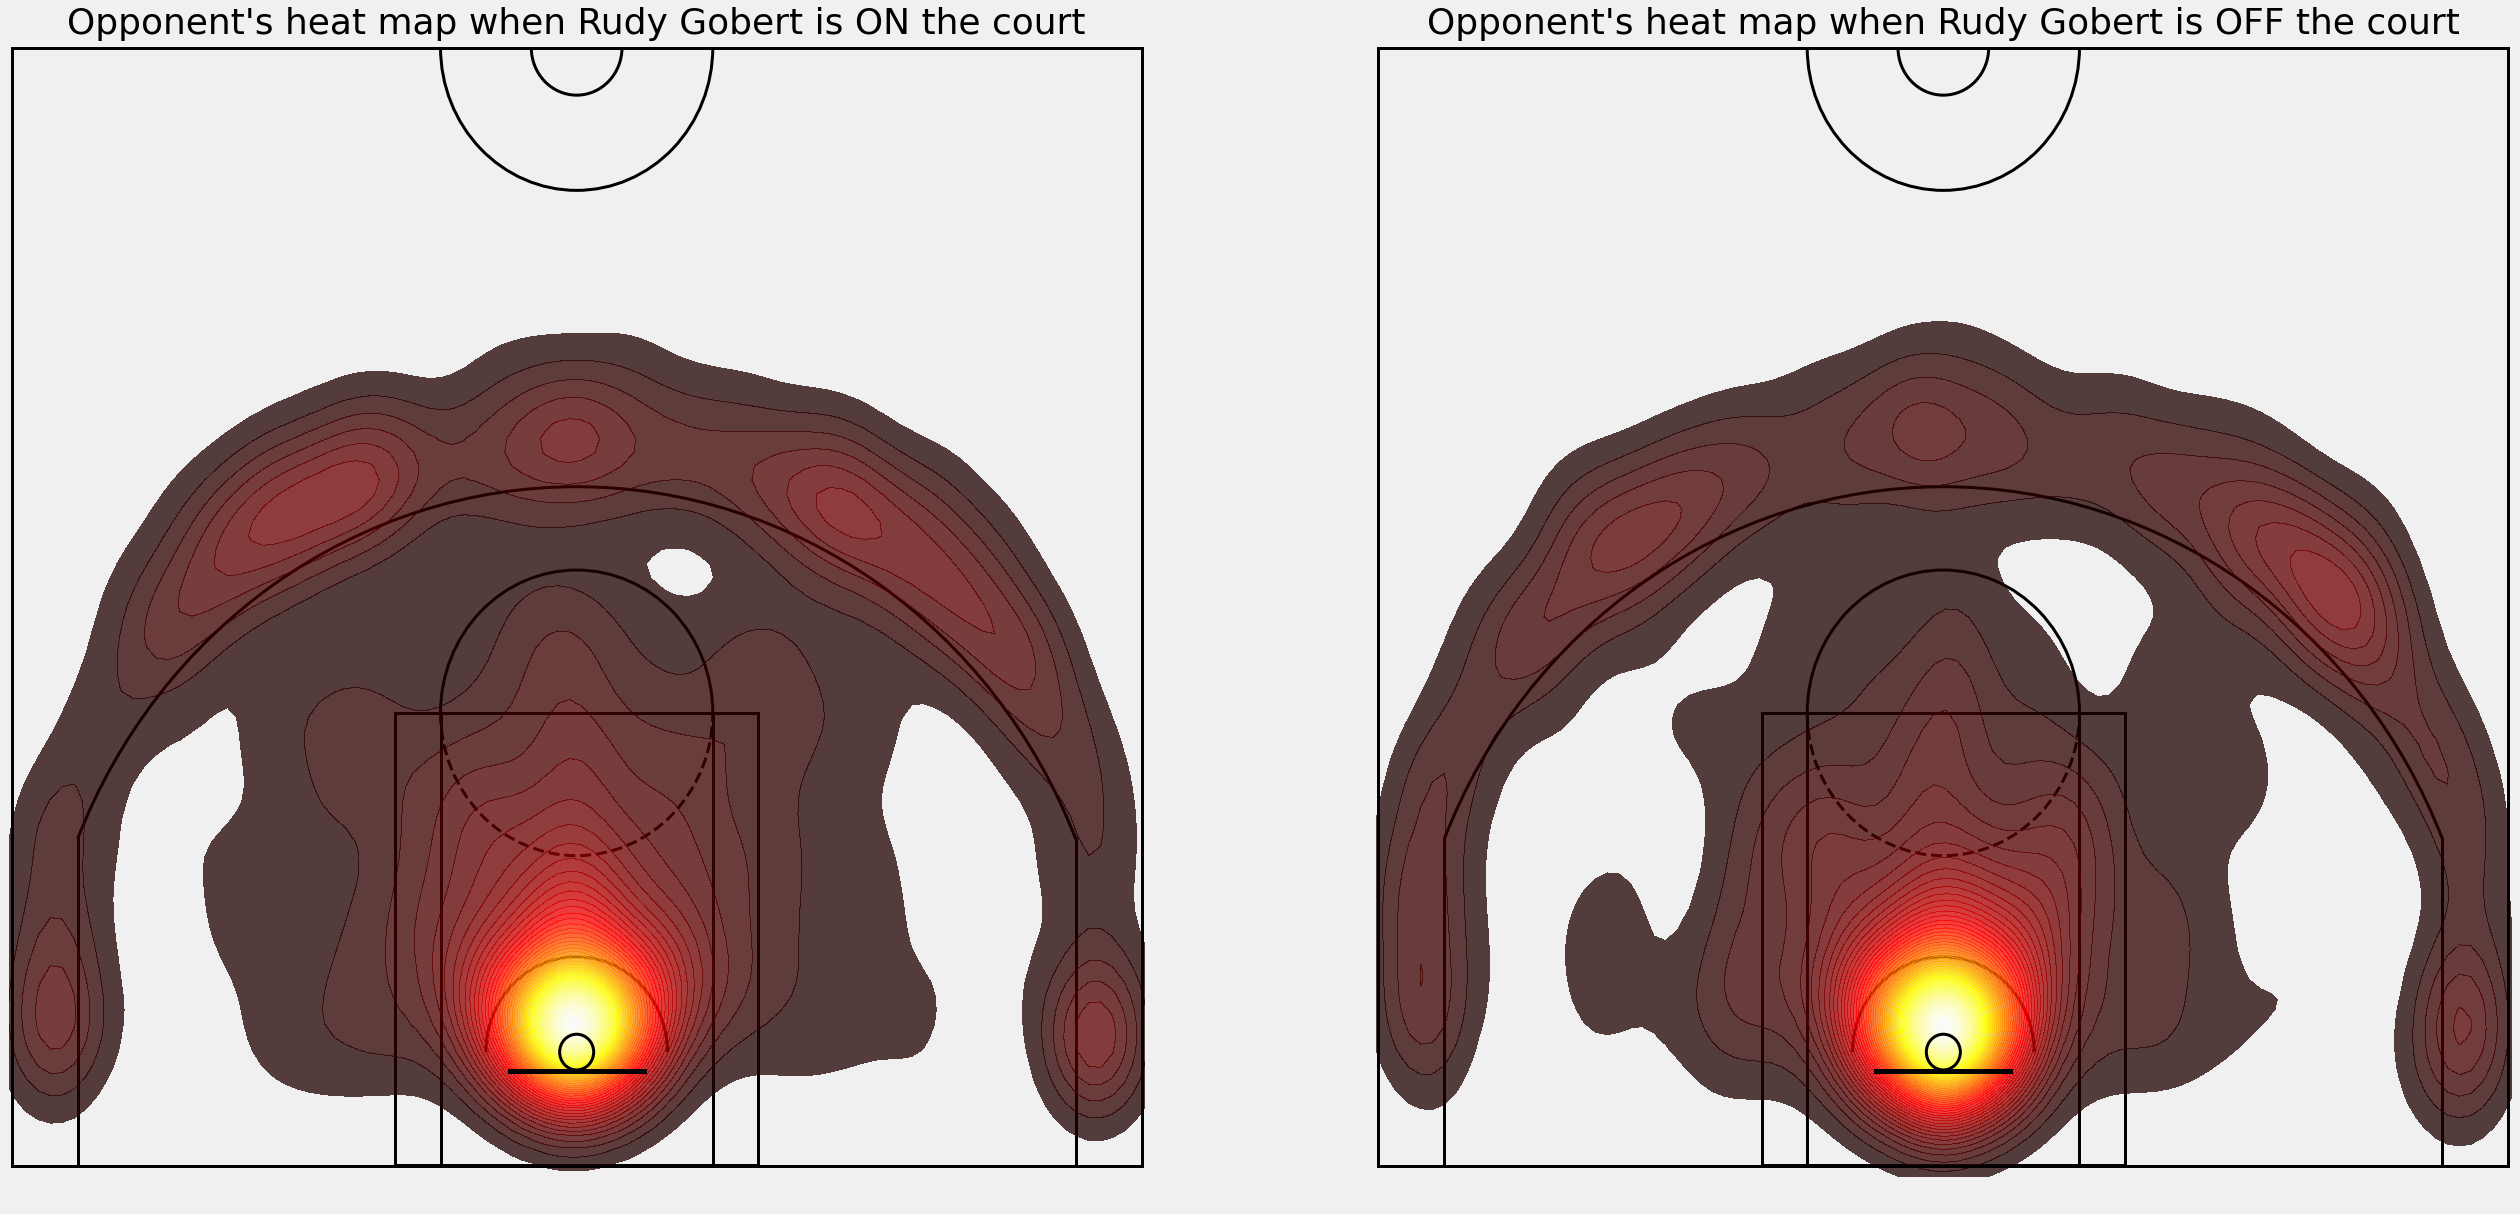

In [125]:
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
ax_1, ax_2 = axes

ax_1.xaxis.set_ticks([])
ax_1.yaxis.set_ticks([])
ax_1.grid(False)
ax_1.set_xlim(-251,251)
ax_1.set_ylim(-65,425)

ax_1.set_title("Opponent's heat map when Rudy Gobert is ON the court", size=36)
sns.kdeplot(data=x_on, data2=y_on, gridsize=100, ax=ax_1, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')
draw_court(ax=ax_1,outer_lines=True, lw=3, color='black')


draw_court(ax=ax_2,outer_lines=True, lw=3, color='black')
ax_2.xaxis.set_ticks([])
ax_2.yaxis.set_ticks([])
ax_2.grid(False)
ax_2.set_xlim(-251,251)
ax_2.set_ylim(-65,425)

ax_2.set_title("Opponent's heat map when Rudy Gobert is OFF the court", size=36)
#sns.kdeplot(data=x_on, data2=y_on, ax=ax, cut=1, fill=True, levels=25, shade=True, shade_lowest=False, alpha=0.75)
sns.kdeplot(data=x_off, data2=y_off, ax=ax_2, gridsize=100, cut=1, fill=True, levels=50, shade=True, shade_lowest=False, alpha=0.75, cmap='hot')

In [150]:
binned_df.loc[:, ['BIN_LOC_X', 'BIN_LOC_Y']]

,BIN_LOC_X,BIN_LOC_Y
0,-41.666667,27.000000
1,-8.333333,10.333333
2,125.000000,10.333333
3,-91.666667,243.666667
4,191.666667,143.666667
5,-8.333333,10.333333
6,191.666667,210.333333
7,225.000000,93.666667
8,-225.000000,10.333333
9,-25.000000,243.666667
